# Jet Compression using an Autoencoder

In [25]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, AE_3D, AE_3D_v2, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [8]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/small_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/small_test.pkl')

train.head(10)

,jet pT,jet eta,jet phi,jet E,photon pT,photon eta,photon phi,photon E
475,56184.804688,1.596269,-0.719975,144772.562500,56184.804688,1.596269,-0.719975,144772.562500
219,75450.203125,0.808926,2.738006,101821.710938,75450.203125,0.808926,2.738006,101821.710938
835,127289.468750,0.574990,-1.221890,149917.093750,127289.468750,0.574990,-1.221890,149917.093750
575,125127.273438,-1.318795,-1.620016,250886.296875,125127.273438,-1.318795,-1.620016,250886.296875
83,217792.937500,1.594345,1.210510,558542.125000,217792.937500,1.594345,1.210510,558542.125000
685,55762.593750,1.550346,2.308717,137591.734375,55762.593750,1.550346,2.308717,137591.734375
821,65898.179688,1.766859,2.647497,198637.156250,65898.179688,1.766859,2.647497,198637.156250
823,127751.414062,-1.732729,0.582633,372619.625000,127751.414062,-1.732729,0.582633,372619.625000
745,137081.906250,-1.245620,-0.315758,258005.218750,137081.906250,-1.245620,-0.315758,258005.218750
499,155053.468750,0.775443,1.669166,204243.109375,155053.468750,0.775443,1.669166,204243.109375


In [9]:
train.pop('photon pT')
train.pop('photon phi')
train.pop('photon eta')
train.pop('photon E')

475    144772.562500
219    101821.710938
835    149917.093750
575    250886.296875
83     558542.125000
           ...      
321    358756.718750
80     484166.968750
908    437513.250000
931    335894.250000
960    162905.171875
Name: photon E, Length: 797, dtype: float32

In [10]:
train

,jet pT,jet eta,jet phi,jet E
475,56184.804688,1.596269,-0.719975,144772.562500
219,75450.203125,0.808926,2.738006,101821.710938
835,127289.468750,0.574990,-1.221890,149917.093750
575,125127.273438,-1.318795,-1.620016,250886.296875
83,217792.937500,1.594345,1.210510,558542.125000
...,...,...,...,...
321,358293.312500,0.050855,-2.605082,358756.718750
80,107214.281250,2.187883,0.665975,484166.968750
908,112327.976562,2.034830,-0.516084,437513.250000
931,117005.390625,1.714986,-2.637105,335894.250000


## Normalizing and splitting into train and test datasets

In [11]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Evaluation

In [12]:
save_path = './models/AE_3D_v2_bs256_loss28eneg7.pt'
model = AE_3D_v2()
#save_path = './models/AE_3D_bs256_loss49eneg7.pt'
#model = AE_3D()
#save_path = './models/AE_big_model_loss48eneg6.pt'
#model = AE_big()
model.load_state_dict(torch.load(save_path))
model.eval()

AE_3D_v2(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [14]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(0, 5):
    data = train_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([-0.9442,  1.0615, -0.3599, -0.4773])
Out: tensor([-0.9331,  1.0656, -0.3600, -0.4984], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.5410,  0.5089,  1.5732, -0.6832])
Out: tensor([-0.5472,  0.5078,  1.5730, -0.6753], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.5440,  0.3448, -0.6405, -0.4527])
Out: tensor([ 0.5469,  0.3446, -0.6402, -0.4589], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.4988, -0.9842, -0.8630,  0.0313])
Out: tensor([ 0.4047, -0.9796, -0.8558,  0.1844], grad_fn=<AddBackward0>)
 
Inp: tensor([2.4382, 1.0601, 0.7193, 1.5058])
Out: tensor([2.4465, 1.0641, 0.7203, 1.4898], grad_fn=<AddBackward0>)
 


In [15]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(0, 5):
    data = train_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 5.6185e+04,  1.5963e+00, -7.1998e-01,  1.4477e+05])
Out: [ 5.6716242e+04  1.6022140e+00 -7.2010458e-01  1.4038080e+05]
 
Inp: tensor([7.5450e+04, 8.0893e-01, 2.7380e+00, 1.0182e+05])
Out: [7.51520703e+04 8.07359695e-01 2.73767495e+00 1.03467375e+05]
 
Inp: tensor([ 1.2729e+05,  5.7499e-01, -1.2219e+00,  1.4992e+05])
Out: [ 1.2742762e+05  5.7479280e-01 -1.2214375e+00  1.4861791e+05]
 
Inp: tensor([ 1.2513e+05, -1.3188e+00, -1.6200e+00,  2.5089e+05])
Out: [ 1.2063136e+05 -1.3122784e+00 -1.6071365e+00  2.8282778e+05]
 
Inp: tensor([2.1779e+05, 1.5943e+00, 1.2105e+00, 5.5854e+05])
Out: [2.1818783e+05 1.5999786e+00 1.2123910e+00 5.5519844e+05]
 


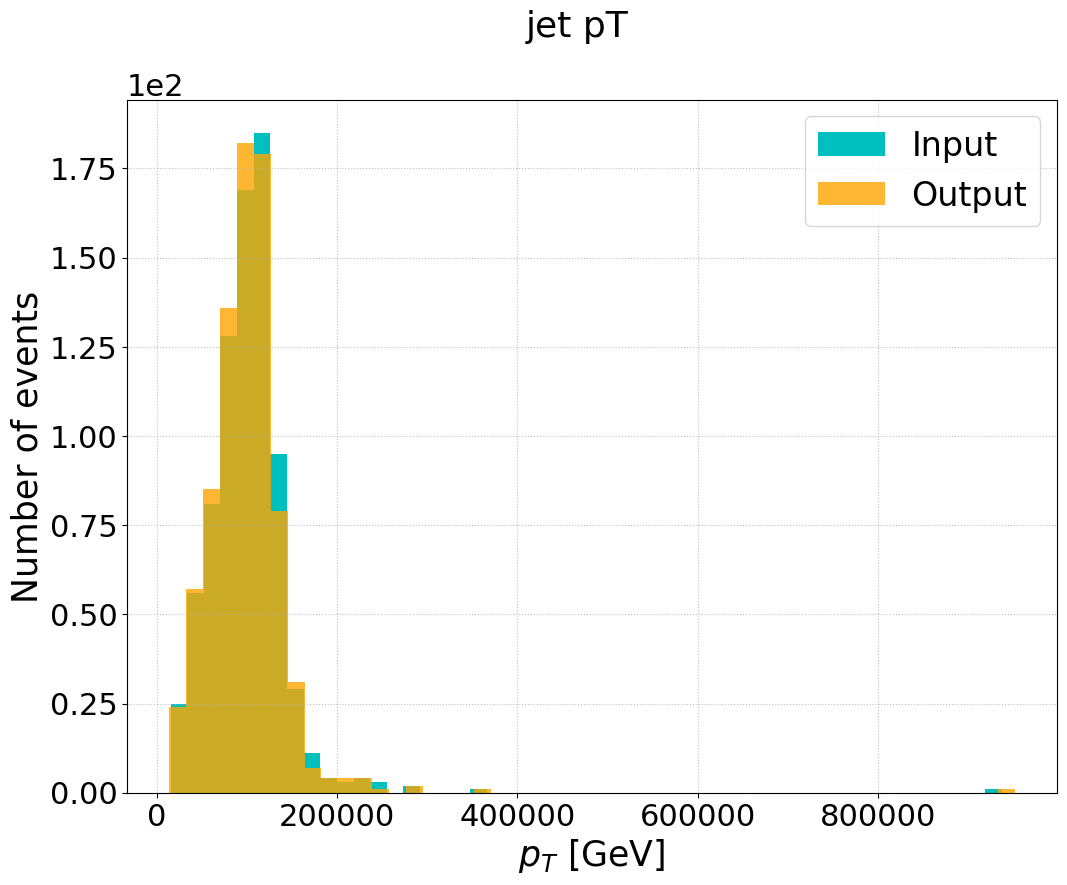

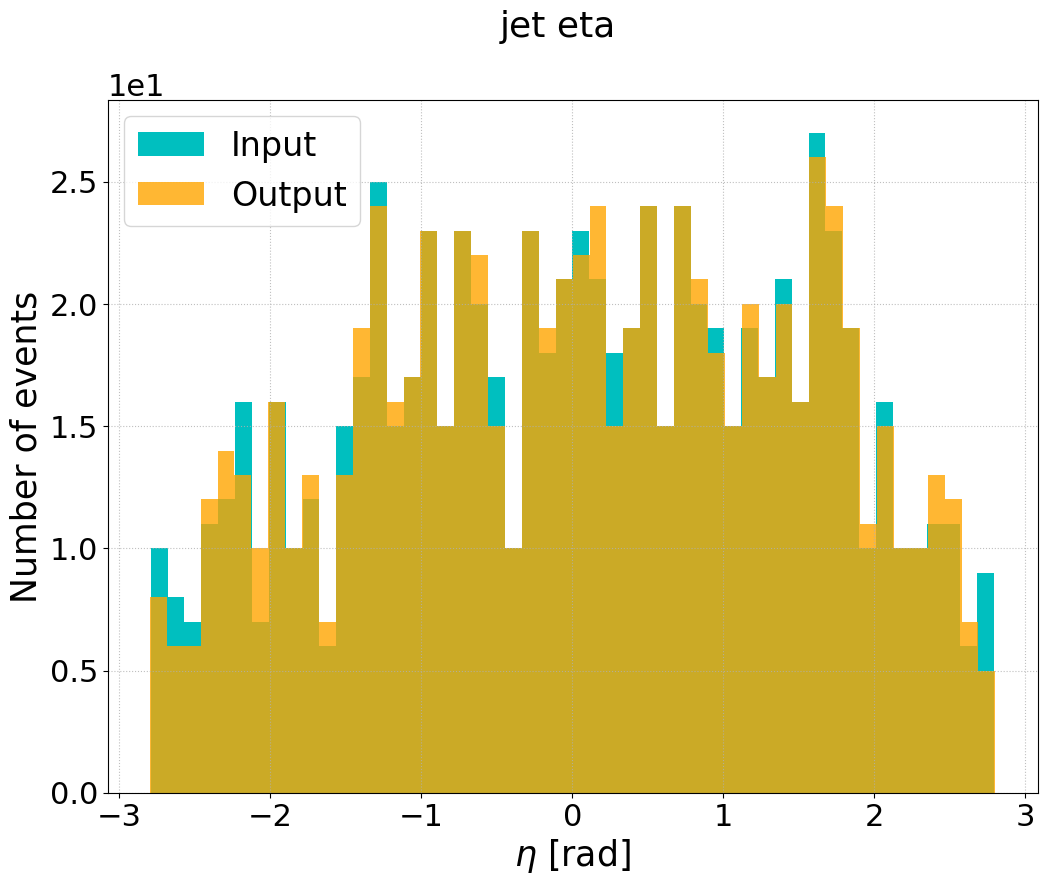

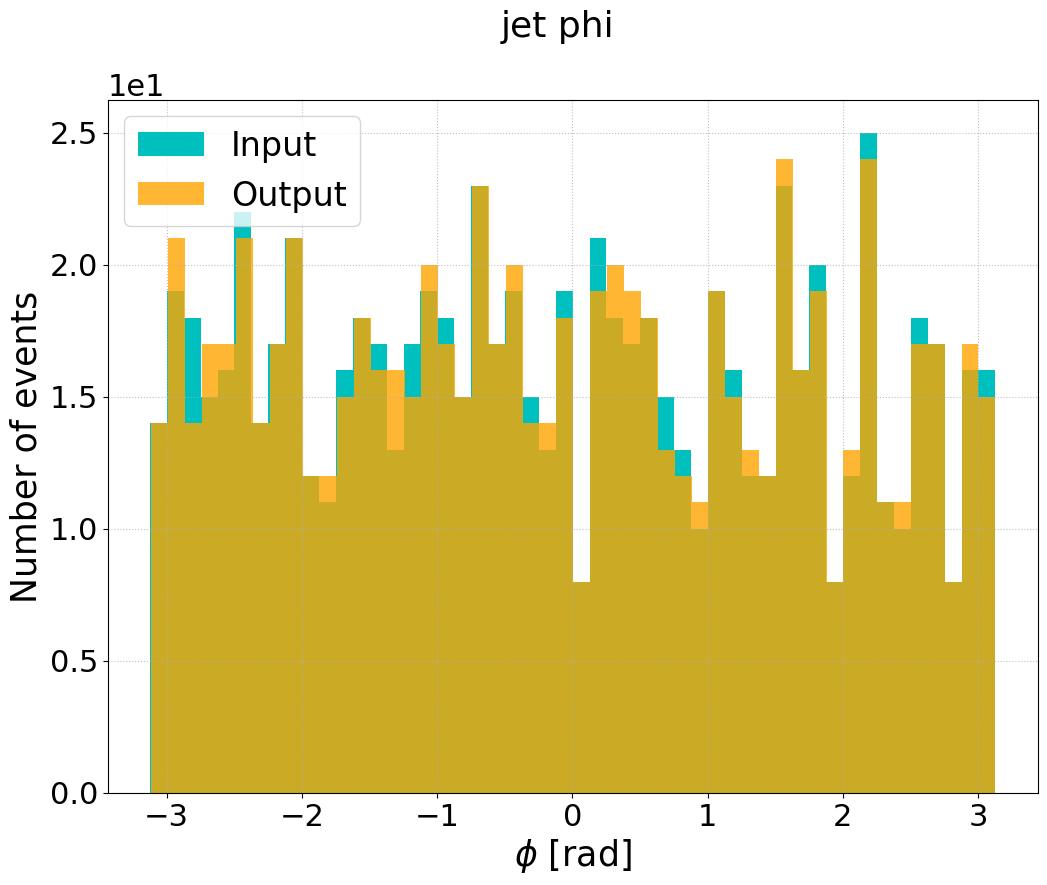

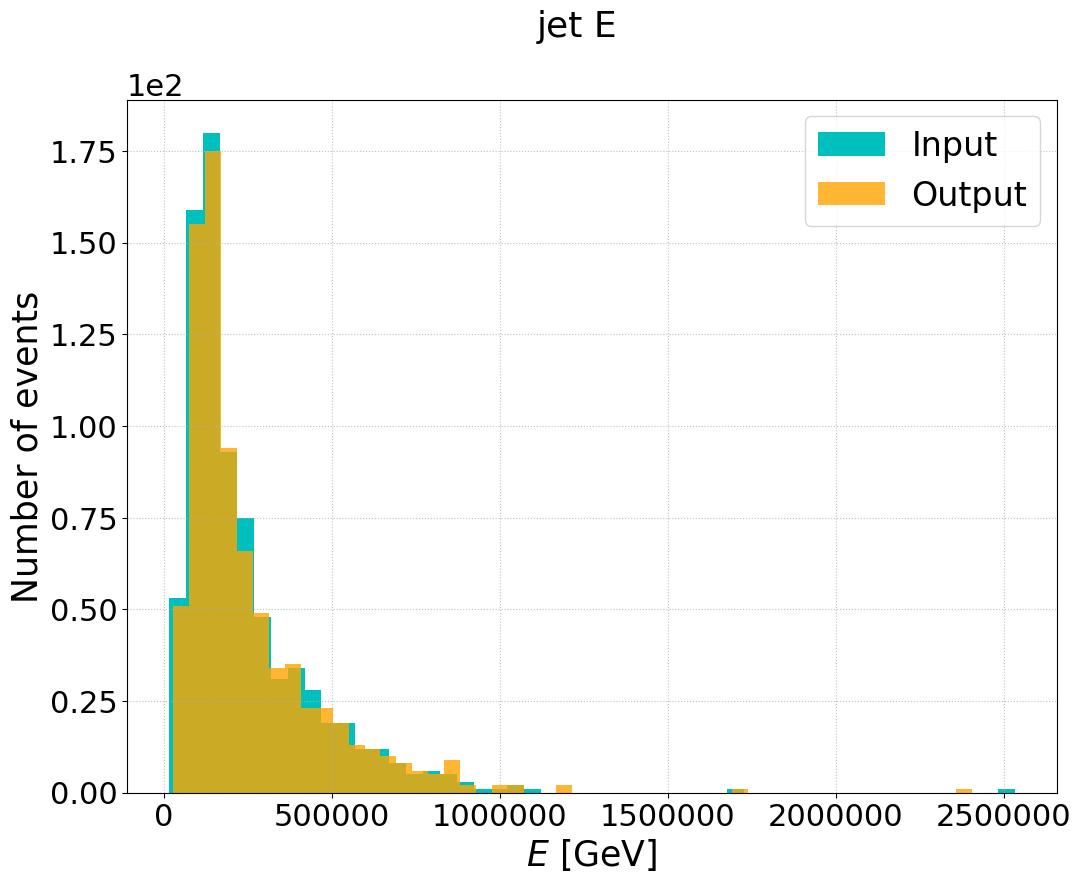

In [26]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
data = torch.tensor(train_x.values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=n_bins)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()

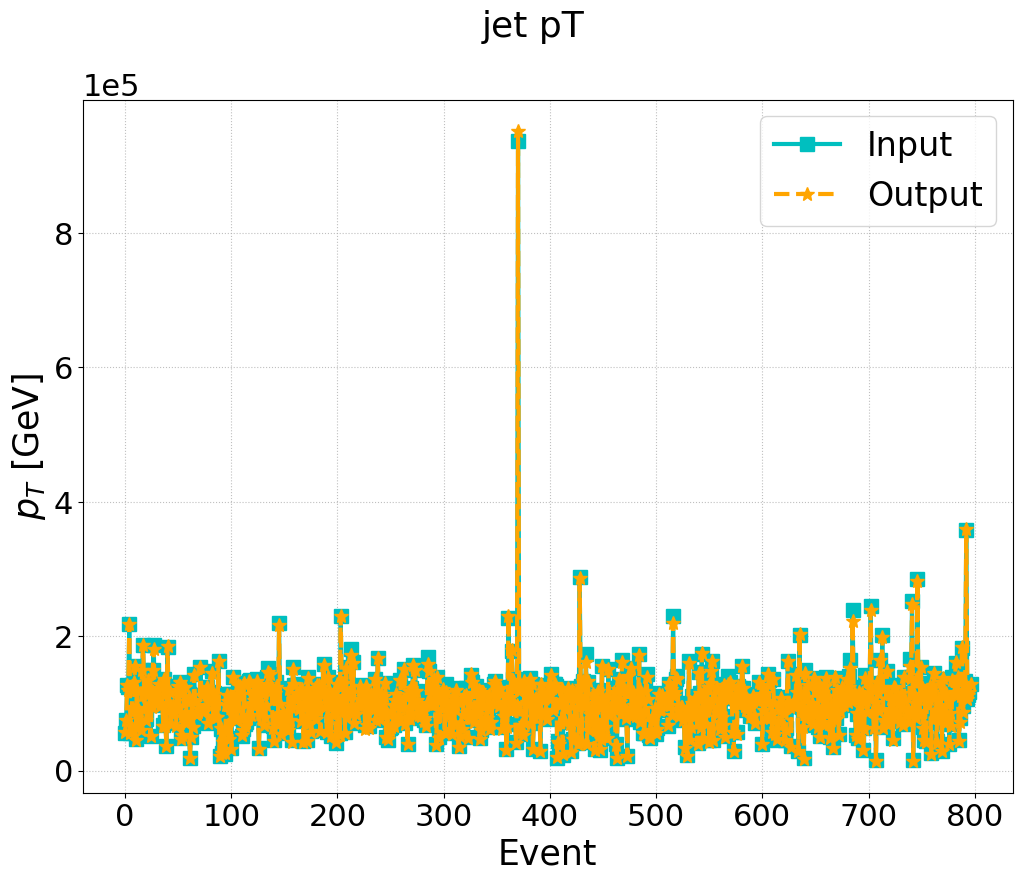

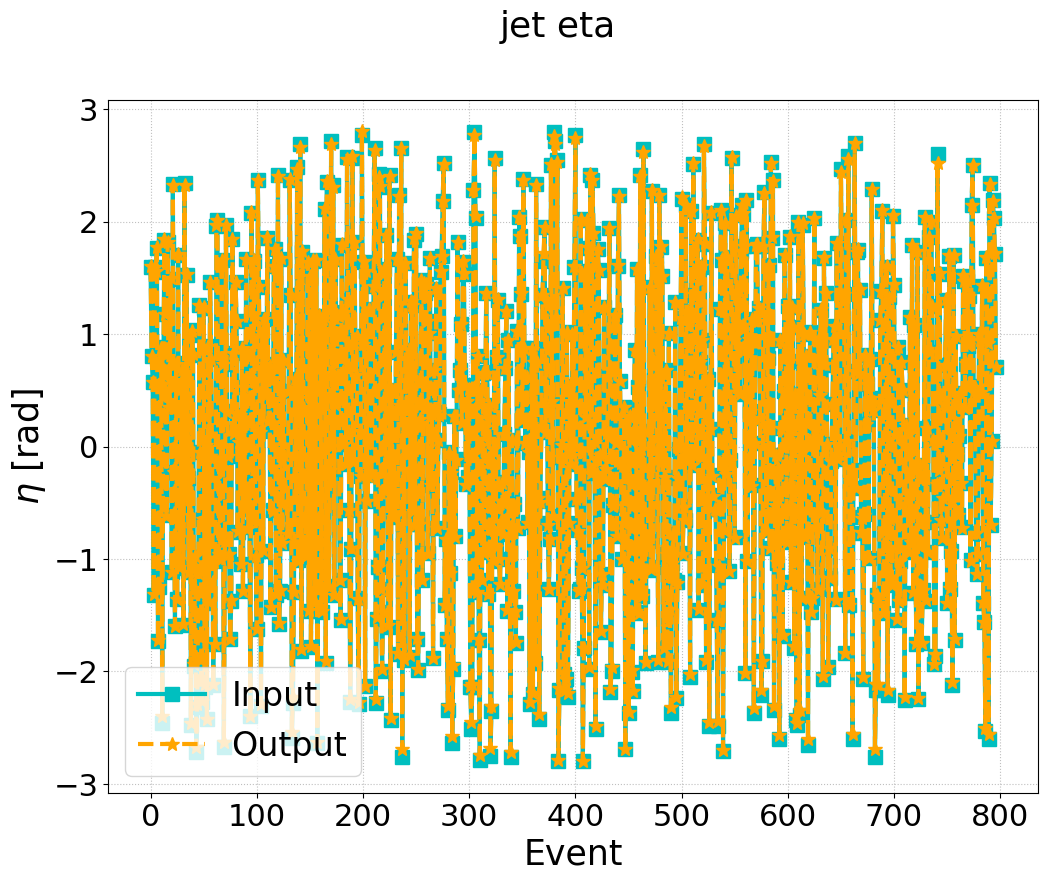

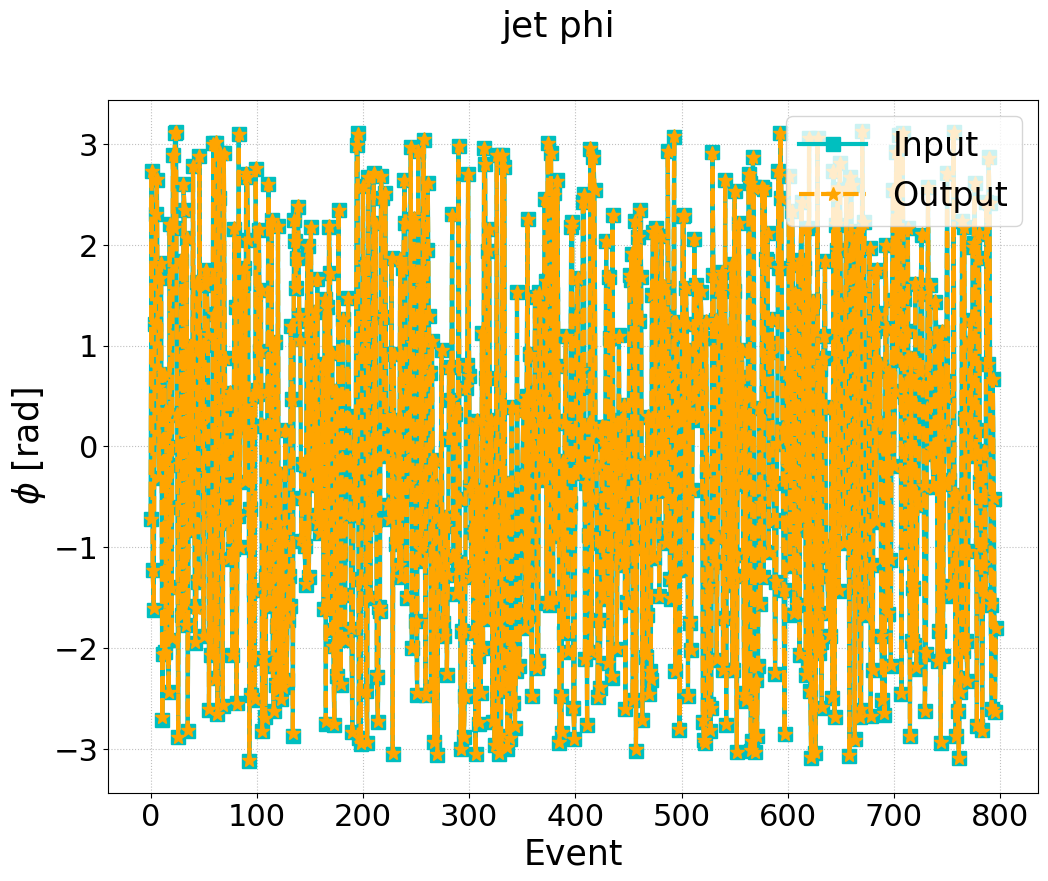

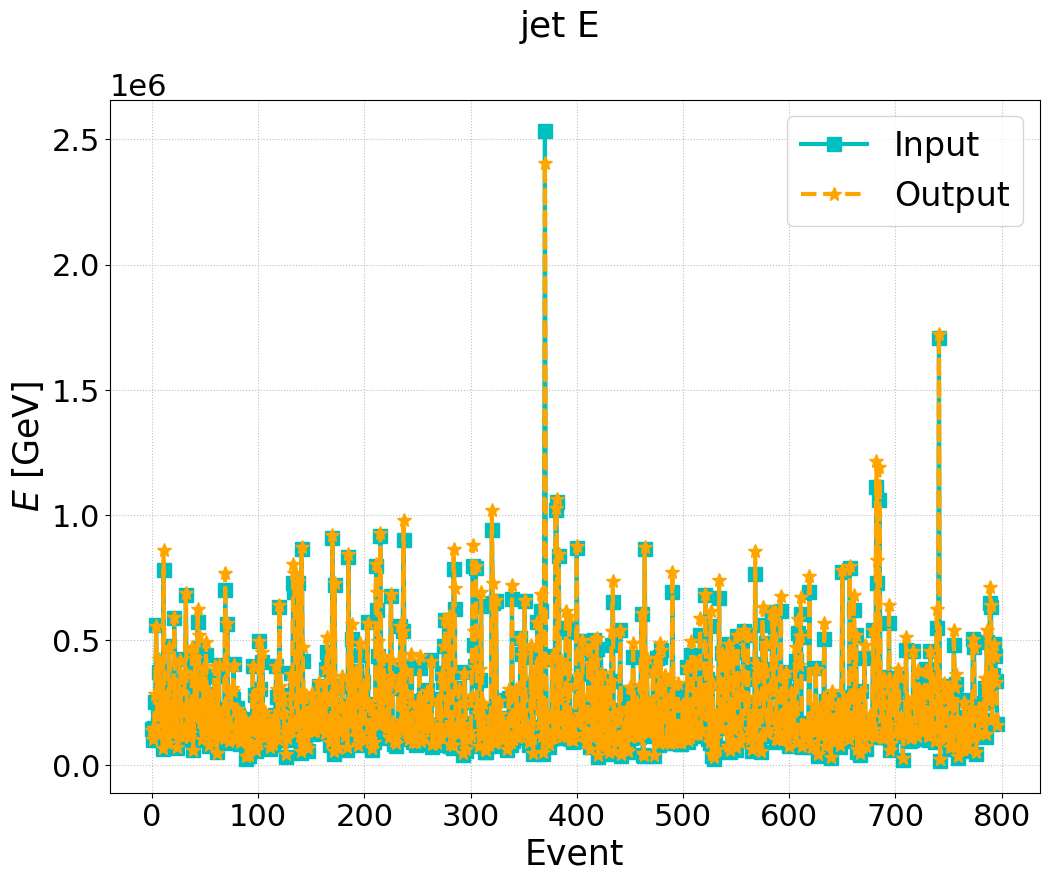

In [27]:
# Plot input on top of output
data = torch.tensor(train_x.values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [28]:
# Plot input on top of output
data = torch.tensor(train_x.values)
latent = model.encode(data).detach().numpy()

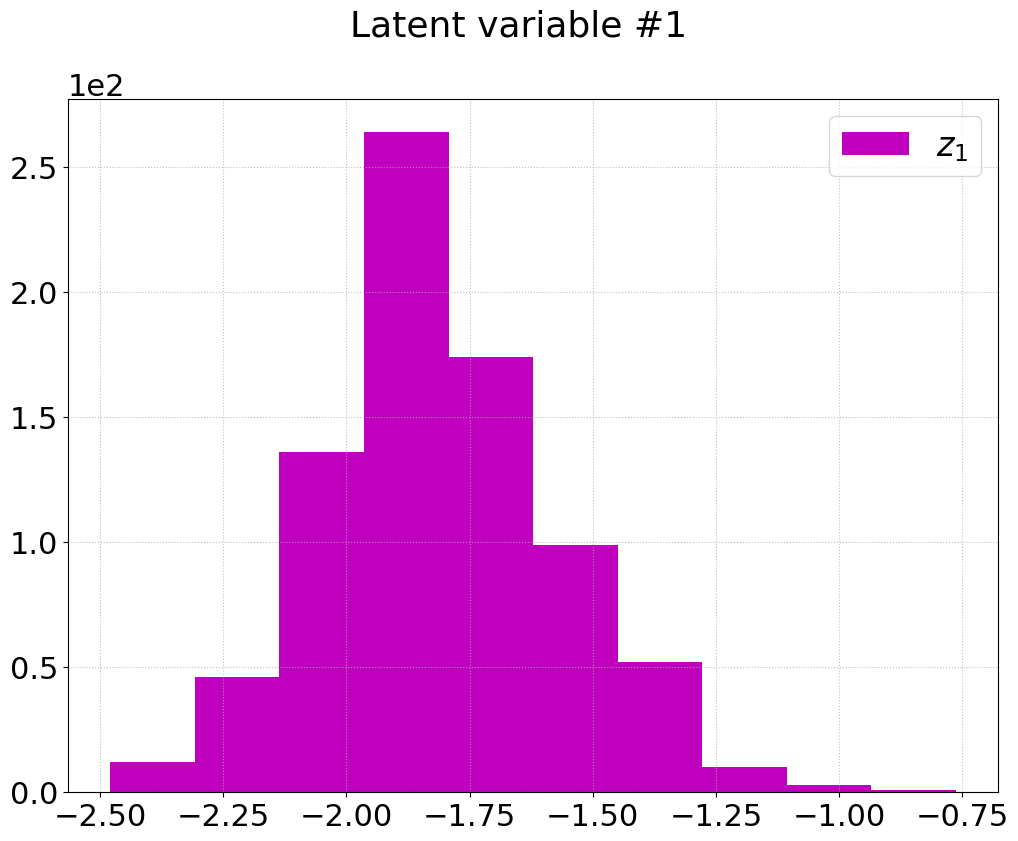

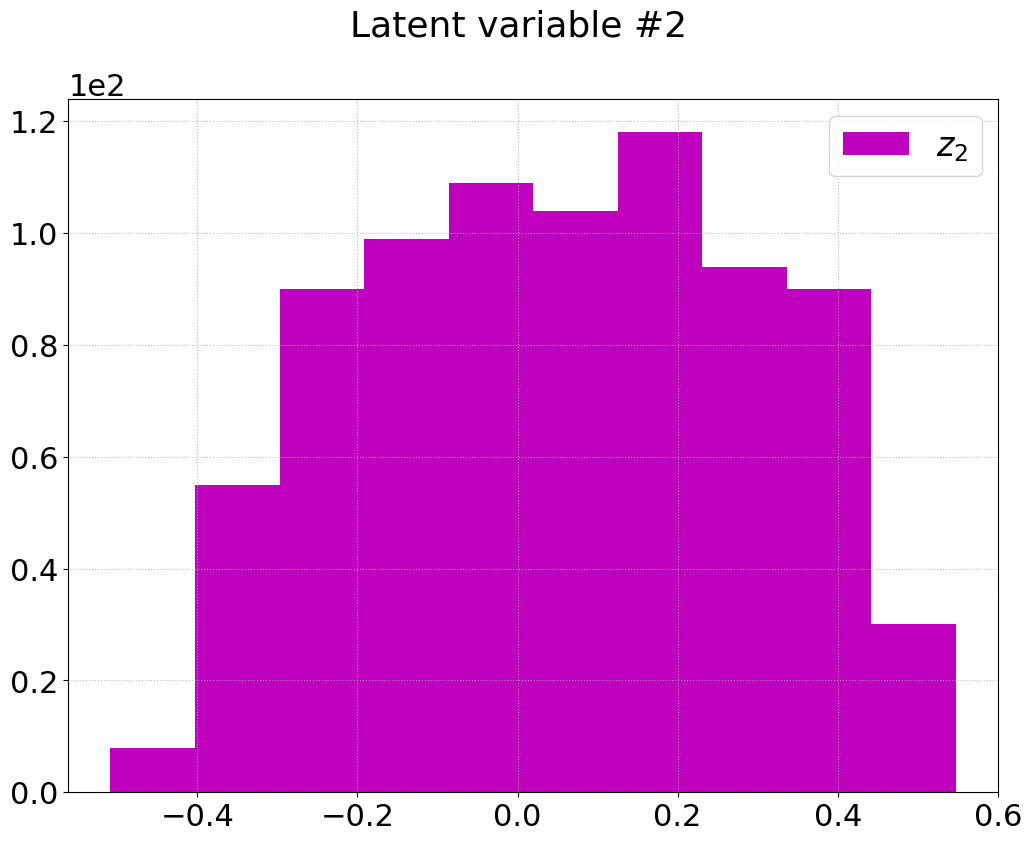

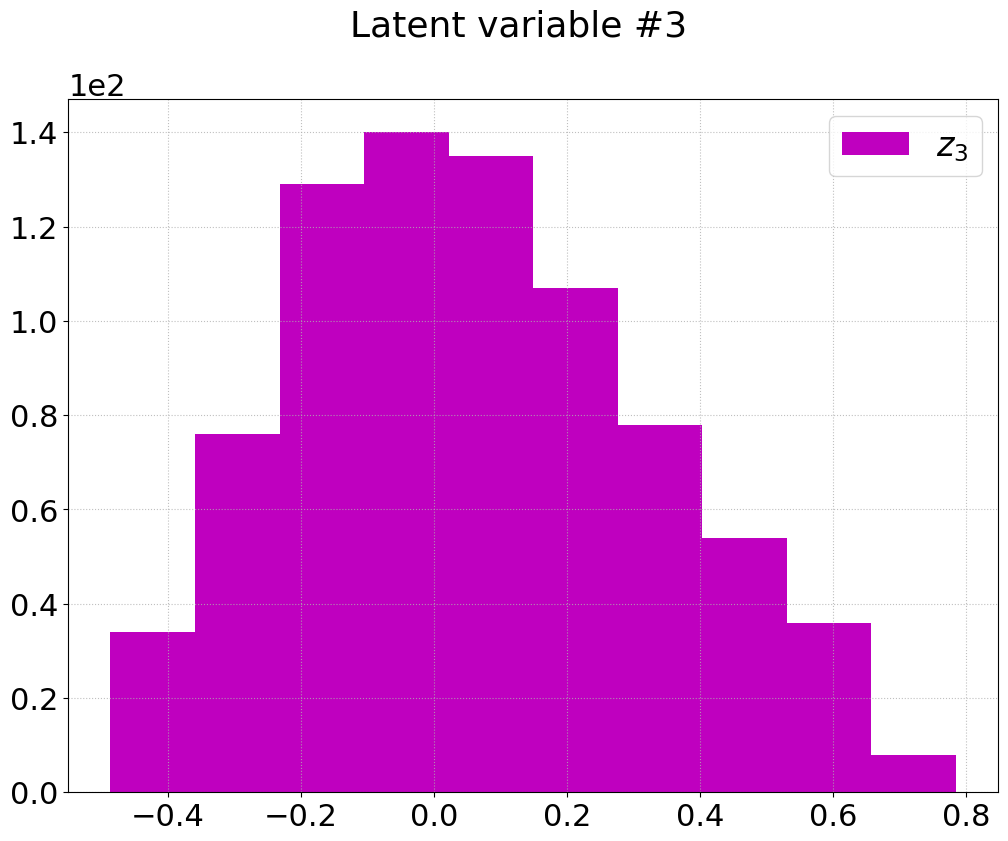

In [29]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

Text(0.5, 0, '$z_3$')

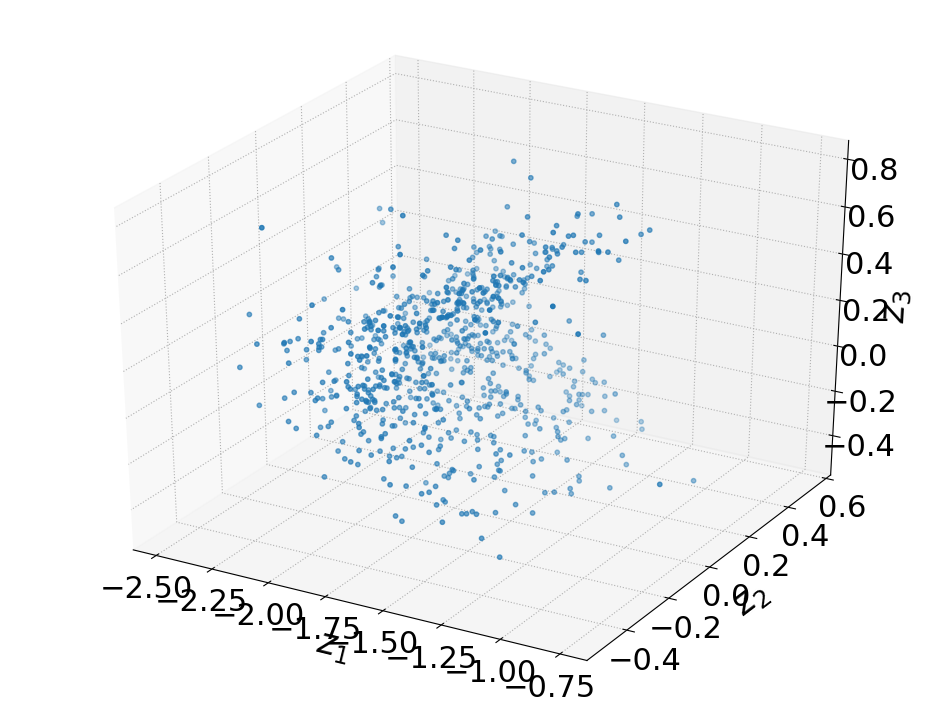

In [30]:
from mpl_toolkits.mplot3d import Axes3D

data = torch.tensor(train_x.values)
latent = model.encode(data).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], s=10)
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$z_3$')

Text(0, 0.5, '$z_3$')

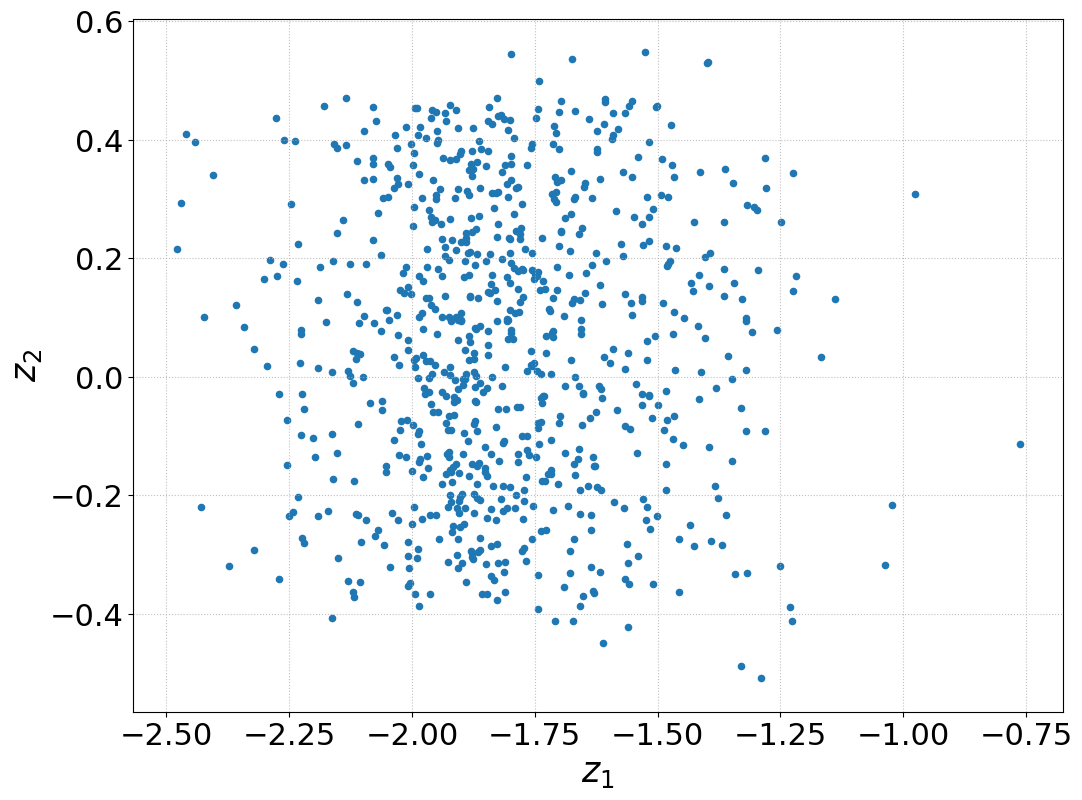

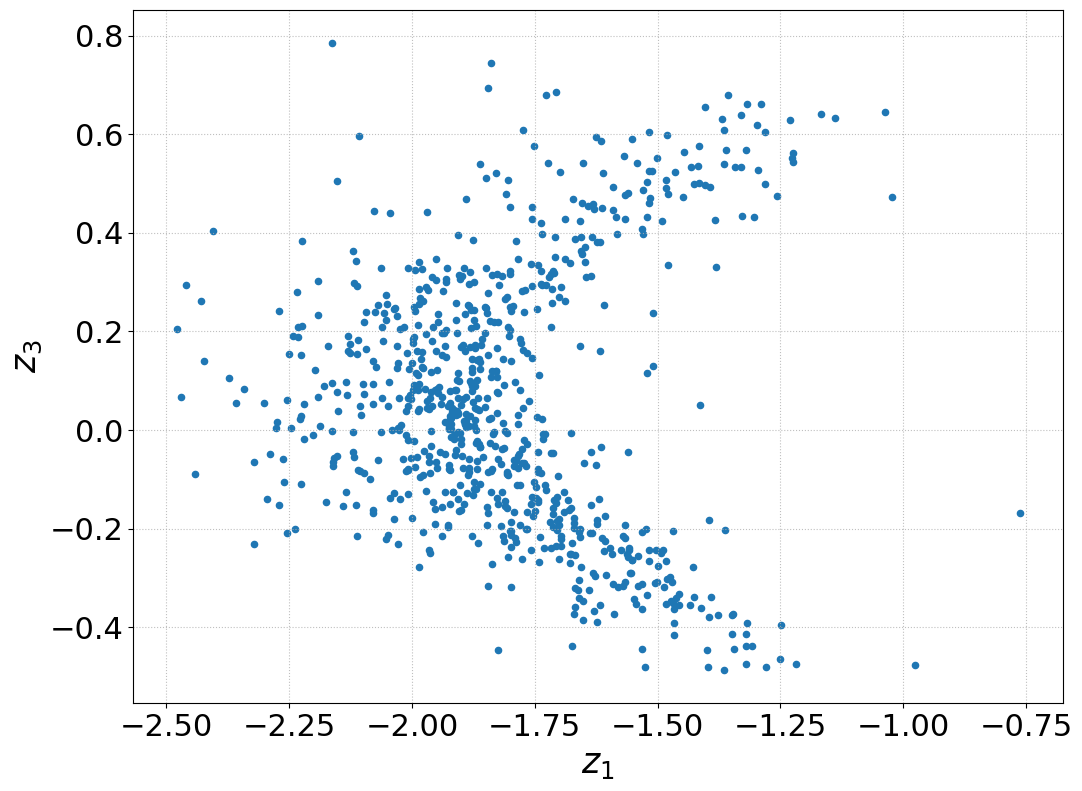

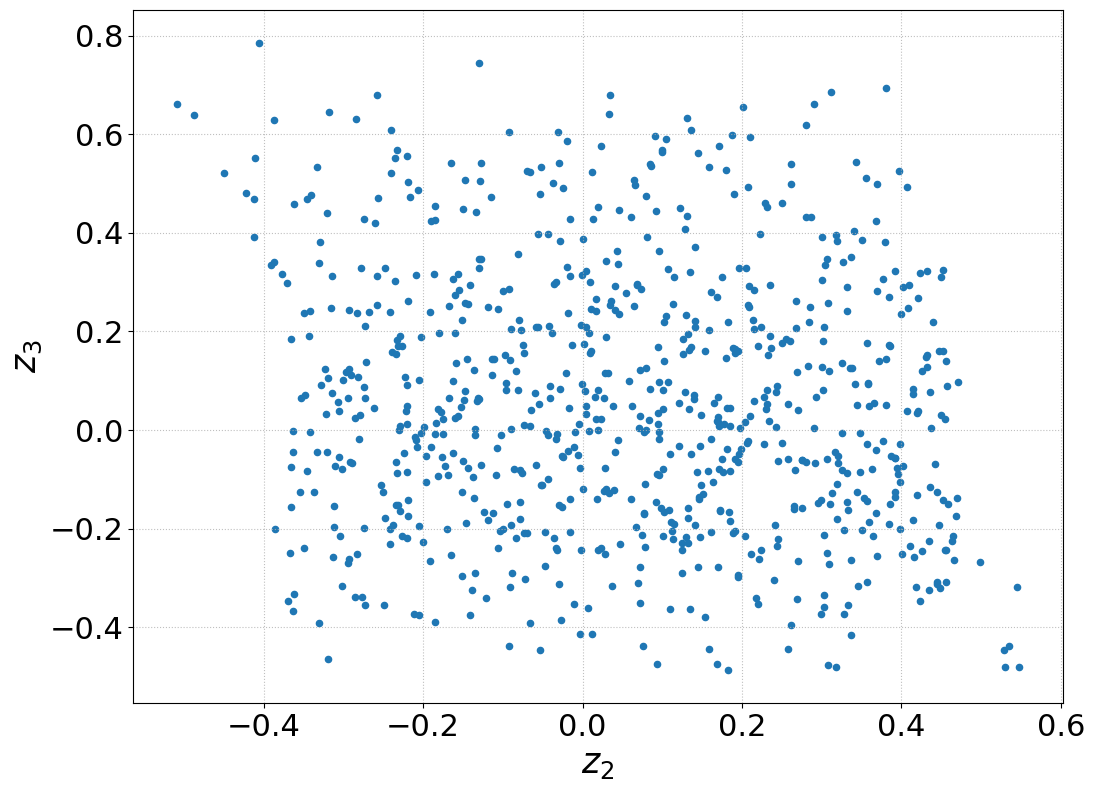

In [31]:
mksz = 20

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')

plt.figure()
plt.scatter(latent[:, 0], latent[:, 2], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_3$')

plt.figure()
plt.scatter(latent[:, 1], latent[:, 2], s=mksz)
plt.xlabel(r'$z_2$')
plt.ylabel(r'$z_3$')